In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import scipy as sp
import scipy.linalg

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image
import torchvision

# Utils

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(train_loss, test_loss):
  fig, axes = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
  # plt.subplots_adjust(left=0.1, bottom=0.1, right=0.15, top=0.15, wspace=0.2, hspace=0.5)
  plt.suptitle("Loss, Kl, reconstrucion loss and negetive elbo plot for train and test data", size=12)
  axes.plot(list(range(1, len(train_loss)+1)), train_loss, 'b', label='train errors')
  axes.plot(list(range(1, len(test_loss)+1)), test_loss, 'r',label='test errors')
  axes.set_ylabel('Loss Average', size=10, labelpad=11)
  axes.set_xlabel('Epoch', size=10, labelpad=5)
  axes.legend(loc='best', fontsize=8)
  axes.grid()

  plt.show()

In [ ]:
def min_max_normalize(x):
    return (x-x.min())/(x.max()-x.min())

In [ ]:
def get_normal_sample(model):
  z = torch.distributions.normal.Normal(0.0, 1.0).sample([16, 28 * 28])
  with torch.no_grad():
      x, _ = model.backward(z.to(device))
  x = x.squeeze().cpu().numpy()
  return x

In [ ]:
def plot_digits(x):
  fig, axes = plt.subplots(4, 4,figsize=(12,12))
  idx = 0
  for i in range(4):
    for j in range(4):
      data = min_max_normalize(x[idx])
      pixels = data.reshape((28, 28))
      axes[i][j].imshow(pixels, cmap='gray')
      idx+=1

# DataLoader

In [ ]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/content/',
                                                          download=True,
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.Resize((28, 28)),
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),
                                           batch_size=batch_size,
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/content/',
                                                          download=True,
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])),
                                           batch_size=batch_size,
                                           shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 115342626.92it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89070363.11it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27540953.26it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8377541.23it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



#Models

In [ ]:
class Scale(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()

        self.scale = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.scale(x)


class Translation(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()

        self.translation = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.translation(x)

## Coupling

In [ ]:
class Coupling(nn.Module):
    def __init__(self, dim, hidden_dim = 8):
        super(Coupling, self).__init__()

        self.s = Scale(dim // 2, dim // 2, hidden_dim)
        self.t = Translation(dim // 2, dim // 2, hidden_dim)

        self.dim = dim

    def forward(self, x):
        x_a, x_b = x[:,:self.dim // 2], x[:,self.dim // 2:]

        t1_transformed = self.t(x_a)
        s1_transformed = self.s(x_a)

        yb = (torch.exp(s1_transformed) * x_b) + t1_transformed
        ya = x_a

        z = torch.cat([ya, yb], dim=1)

        log_det_jacobian = torch.sum(s1_transformed, dim=1)

        return z, log_det_jacobian

    def backward(self, z):
        z_a, z_b = z[:,:self.dim // 2], z[:,self.dim // 2:]

        t1_transformed = self.t(z_a)
        s1_transformed = self.s(z_b)

        z_b = (z_b - t1_transformed) * torch.exp(-s1_transformed)

        z = torch.cat([z_a, z_b], dim=1)

        inv_log_det_jacobian = torch.sum(-s1_transformed, dim=1)

        return z, inv_log_det_jacobian

## Real NVP

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

class RealNVP(nn.Module):

    def __init__(self, dim, layers):
        super().__init__()
        self.prior = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        bsz, _ = x.shape
        log_det = torch.zeros(bsz, device=device)
        for layer in self.layers:
            x, log_det_jacobian = layer.forward(x)
            x = x.flip(1)
            log_det += log_det_jacobian
        prior_logprob = self.prior.log_prob(x)
        return x, prior_logprob, log_det

    def backward(self, z):
        shp, _ = z.shape
        log_det = torch.zeros(shp, device=device)
        for layer in self.layers[::-1]:
            z, inv_log_det = layer.backward(z)
            log_det += inv_log_det
        return z, log_det

# Test

In [ ]:
def test(test_loader, epoch, device):
    val_loss = 0
    model.eval()
    loop_test = tqdm(enumerate(test_loader, 1), total=len(test_loader), desc="Test", position=0, leave=True)
    for batch_index, training_sample in loop_test:
        img = training_sample[0].to(device)
        batch_len = img.size(0)
        img_vector = img.reshape(batch_len, -1)
        z, prior_logprob, log_det = model(img_vector)

        logprob = prior_logprob + abs(log_det)
        loss = -torch.mean(logprob)

        val_loss += loss

        loop_test.set_description(f"Test - iteration : {epoch}")
        loop_test.set_postfix(
          loss_batch="{:.4f}".format(val_loss.detach().item() / batch_index),
          refresh=True,
    )

    val_loss /= len(loop_test)
    return val_loss


# Train

In [ ]:
def train(model, train_loader, test_loader, epochs, batch_size, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    validation_losses = []
    model.to(device)
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        epoch_loss = 0
        loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
        for batch_index, training_sample in loop_train:

            optimizer.zero_grad()

            img = training_sample[0].to(device)
            batch_len = img.size(0)
            img_vector = img.reshape(batch_len, -1)
            z, prior_logprob, log_det = model(img_vector)

            logprob = prior_logprob + abs(log_det)
            loss = -torch.mean(logprob)

            loss.backward()
            optimizer.step()

            epoch_loss += loss

            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
              loss_batch="{:.4f}".format(epoch_loss.detach().item() / batch_index),
              refresh=True,
        )

        epoch_loss /= len(train_loader)
        train_losses.append(np.copy(epoch_loss.detach().cpu().numpy()))

        val_loss = test(test_loader, epoch, device)
        validation_losses.append(np.copy(val_loss.detach().cpu().numpy()))


    return model, train_losses, validation_losses

# Main

100%|██████████| 200/200 [1:11:47<00:00, 21.54s/it]


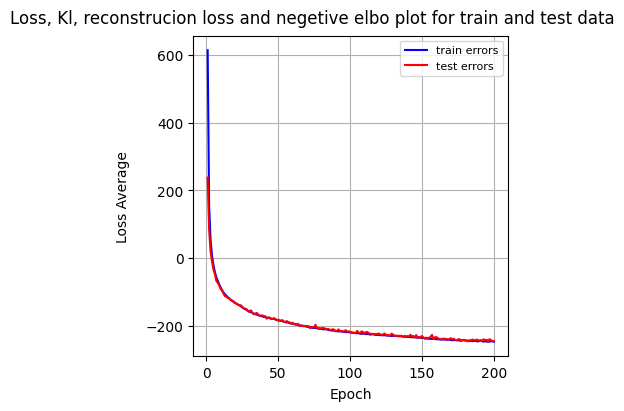

In [ ]:
num_layers = 4
dim = 1 * 28 * 28
layer = Coupling
device = 'cuda'
epochs = 200
batch_size = 256

layers = [layer(dim=dim) for _ in range(num_layers)]

model = RealNVP(dim=dim, layers=layers)

model, train_loss, test_loss = train(model, train_loader, test_loader, epochs, batch_size, device)

plot_acc_loss(train_loss, test_loss)

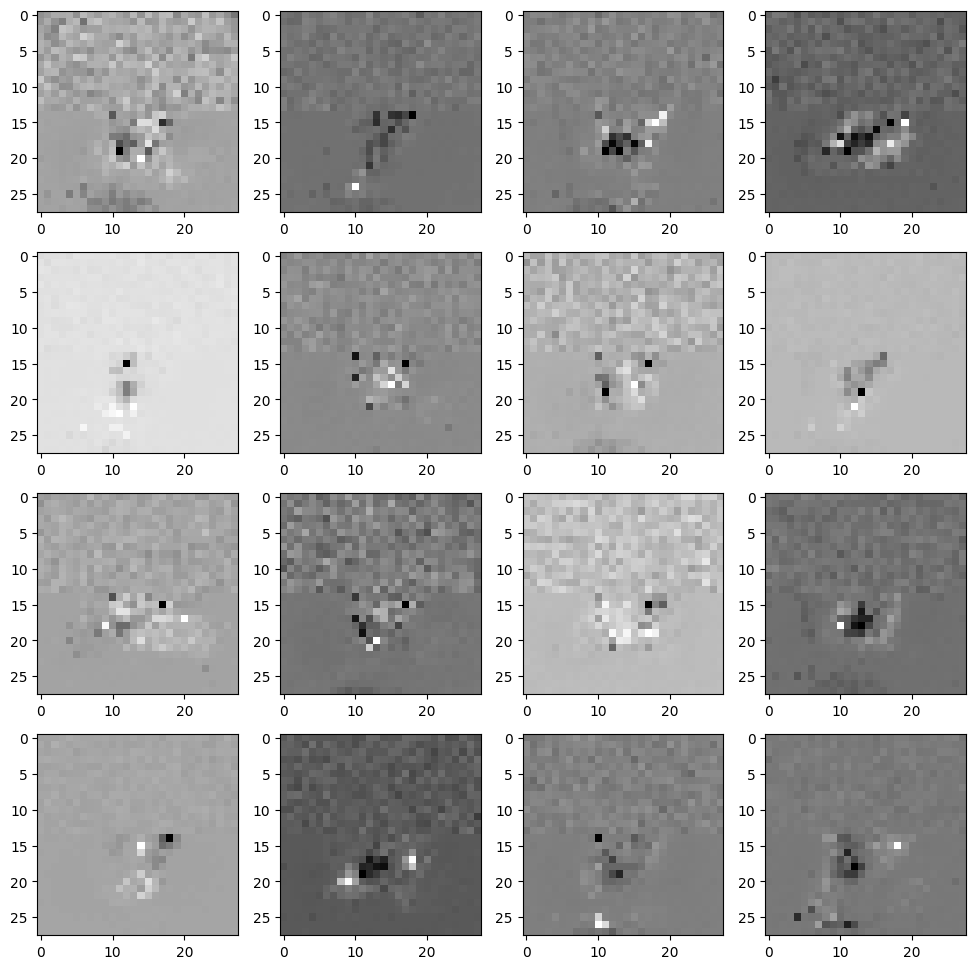

In [ ]:
x = get_normal_sample(model)
plot_digits(x)